In [9]:
import numpy as np
import pandas as pd
import scipy as sp

from scipy import sparse

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import string
import re
import glob

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, FeatureHasher

import keras
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential

# keras architecture visualization
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

from IPython.display import SVG

import matplotlib.pyplot as plt

print('Keras version: %s' % keras.__version__)

PATH = "data/aclImdb"

Keras version: 2.1.5


In [2]:
# or use nltk or spacy
htmltag = re.compile(r'<.*?>')
numbers = re.compile(r'[0-9]')
quotes = re.compile(r'\"|`')
punctuation = re.compile(r'([%s])'% string.punctuation)
english_stopwords =set(stopwords.words('english'))
stemmer = PorterStemmer()

In [3]:
# read files in the given tree, using subfolders as the target classes
def read_files(folder, subfolders):
    corpus, labels = [], []
    for index, label in enumerate(subfolders):
        path = '/'.join([folder, label, '*.txt'])
        for filename in glob.glob(path):
            corpus.append(open(filename, 'r').read())
            labels.append(index)
    return corpus, np.array(labels).astype(np.int)

# pre-processor
def preprocess(s):
    # lowercase
    s = s.lower()
    # remove html tags
    s = htmltag.sub(' ', s)
    # remove numbers
    s = numbers.sub(' ', s)
    # remove quotes
    s = quotes.sub(' ', s)
    # replace puctuation
    s = punctuation.sub(' ', s)
    return s
    
# tokenization
def tokenize(s):
    # use a serious tokenizer
    tokens = nltk.word_tokenize(s)
    # remove stopwords
    tokens = filter(lambda w: not w in english_stopwords, tokens)
    # stem words
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

In [4]:
#coprus_train_pos = [open(filename, 'r').read() for filename in glob.glob(PATH + '/train/pos/*.txt')]
#coprus_train_neg = [open(filename, 'r').read() for filename in glob.glob(PATH + '/train/neg/*.txt')]
corpus_train, y_train = read_files(PATH + '/train', ['neg', 'pos'])
corpus_test, y_test = read_files(PATH + '/test', ['neg', 'pos'])

In [5]:
len(corpus_train), len(y_train), corpus_train[0], y_train[0], corpus_train[24999], y_train[24999]

(25000,
 25000,
 'Hi, Everyone, If you saw "Singing in the Rain," you remember the scene of Gene Kelly dancing in the rain. You also remember the dance number of Donald O\'Connor, "Make \'em Laugh." If you saw "Royal Wedding," you will remember Fred Astaire dancing on the ceiling. If you saw "Jailhouse Rock," you will even remember the title dance number choreographed by The King himself.<br /><br />That is what is missing here. There could have been some blockbuster dance numbers in this presentation. The closest was Chuck McGowan\'s "I Can Do That." the mere fact that you have some talented people on stage moving together does not make a great dance film. Richard Attenborough was to blame for this failure. He pointed the camera at the stage and thought that would be a good thing.<br /><br />Yelling at people auditioning for a part in a Broadway production is not entertainment. Michael Douglas would be just as badly cast if he were in a Western or a comedy. He is OK when he is in a Mi

In [6]:
len(corpus_test), len(y_test), corpus_test[0], y_test[0]

(25000,
 25000,
 'Yes, in this movie you are treated to multiple little snowmen on the attack in apparently a very warm climate so yes this movie is definitely not to be taken seriously. It is in fact a much worse movie than the original as at least with that one the whole production looked like it cost more than a couple of bucks and a video camera to make. It has its funny moments, but really playing off the cheapness of your movie and making that be your intended laughs is kind of weak film making if you ask me. You can not come up with a good story, your effects are going to really be bad, hey let us just make the movie look as bad as possible with horrible one liners and we have our movie. The first one at least had a somewhat credible story as the snowman in that one attacked during the winter and not what amounts to a resort. It also had better effects too, this one is just a step or two ahead of "Hobgoblins" as far as the monsters are concerned and you really want to be more th

In [7]:
# create word index matrix
class WordIndexVectorizer():
    def __init__(self, preprocessor, tokenizer, max_length=None):
        self.vocab, self.distrib = {}, {}
        self.vocab_size, self.sentence_max_len, self.stopword_index = 1, 0, 0
        self.preprocessor, self.tokenizer = preprocessor, tokenizer
        self.max_length = max_length
        
    def fit_transform(self, sentences, learn_tokens=True):
        """Transform sentences into a term index matrix and learning token indexes. To be called on training set.
        Arguments:
            sentences: a collection of sentences
        """
        term_idx_matrix, lengths = [], []
        # map each sentence in the input into a list of indices
        for sentence in sentences:
            sentence = sentence.decode('utf-8')
            indices = []
            # clean the sentence into tokens
            processed = self.preprocessor(sentence)
            tokens = self.tokenizer(processed)
            for token in tokens:
                if learn_tokens and not token in self.vocab:
                    self.vocab[token] = self.vocab_size
                    self.vocab_size += 1
                indices = self.__addToken(indices, token)
                # check if max sentence lenght is reached, otherwise ignore everything else
                if self.isMaxAuthorizedLengthReached(indices):
                    break
            # update the max sentence length
            if len(indices) > self.sentence_max_len:
                self.sentence_max_len = len(indices)
            lengths.append(len(indices))
            indices = self.__padWithStopWords(indices)
            term_idx_matrix.append(indices)
        # pad stop words to the end of each sentence
        #for indices in term_idx_matrix:
        #    
        #    if len(indices) == self.sentence_max_len:
        #        continue
        #    for i in range(self.sentence_max_len - len(indices)):
        #        indices.append(self.stopword_index)
        
        # return result
        term_idx_matrix = np.array(term_idx_matrix)
        return term_idx_matrix, lengths

    def transform(self, sentences):
        """Transform sentences into a term index matrix without learning token indexes. To be called on test set.
        Arguments:
            sentences: a collection of sentences
        """
        term_idx_matrix, lengths = [], []
        # map each sentence in the input into a list of indices
        for sentence in sentences:
            sentence = sentence.decode('utf-8')
            indices = []
            # clean the sentence into tokens
            processed = self.preprocessor(sentence)
            tokens = self.tokenizer(processed)
            for token in tokens:
                # ignore non known tokens
                if token in self.vocab:
                    indices = self.__addToken(indices, token)
                # check if max sentence lenght is reached, otherwise ignore everything else
                if self.isMaxAuthorizedLengthReached(indices):
                    break
            lengths.append(len(indices))
            # pad stop words to the end of each sentence
            indices = self.__padWithStopWords(indices)
            term_idx_matrix.append(indices)
        # return result
        term_idx_matrix = np.array(term_idx_matrix)
        return term_idx_matrix, lengths

    def __addToken(self, indices, token):
        index = self.vocab[token]
        indices.append(index)
        if index not in self.distrib:
            self.distrib[index] = 0
        self.distrib[index] = self.distrib[index] + 1
        return indices
        
    def __padWithStopWords(self, indices):
        index = self.stopword_index
        if index not in self.distrib:
            self.distrib[index] = 0
        if len(indices) < self.max_length:
            for i in range(self.max_length - len(indices)):
                indices.append(self.stopword_index)
                self.distrib[index] = self.distrib[index] + 1
        return indices
    
    def isMaxAuthorizedLengthReached(self, tokens_list):
        return self.max_length is not None and len(tokens_list)>=self.max_length
    
    @property
    def get_sentence_max_len(self):
        return self.sentence_max_len

    @property
    def get_vocab_size(self):
        return self.vocab_size


In [8]:
indexer = WordIndexVectorizer(preprocessor=preprocess, tokenizer=tokenize, max_length=500)
term_idx_train, lengths_train = indexer.fit_transform(corpus_train)
term_idx_test, lengths_test = indexer.transform(corpus_test)

In [10]:
print(term_idx_train.shape)
print(term_idx_test.shape)

(25000, 500)
(25000, 500)


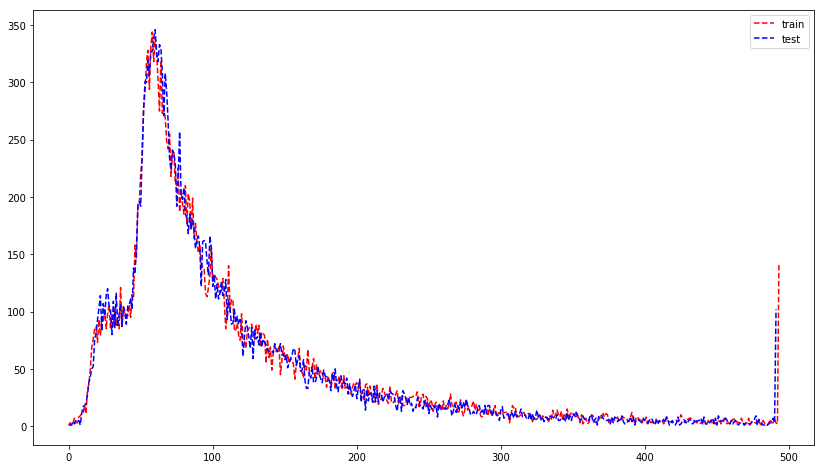

In [11]:
distribution = {"train": {}, "test": {}}

for length in lengths_train:
    if length not in distribution["train"]:
        distribution["train"][length] = 0
    distribution["train"][length] = distribution["train"][length] + 1

for length in lengths_test:
    if length not in distribution["test"]:
        distribution["test"][length] = 0
    distribution["test"][length] = distribution["test"][length] + 1

#plt.subplot(1, 2, 1)
x1 = range(len(distribution["train"]))
x2 = range(len(distribution["test"]))
# red dashes, blue squares and green triangles
plt.figure(figsize=(14, 8))
plt.plot(x1, distribution["train"].values(), 'r--', x2, distribution["test"].values(), 'b--')
#plt.subplot(1, 2, 2)
plt.legend(['train', 'test'])
plt.show()
# the spike at the end of the tail is due to the fact that we truncated long sentences to max_length=500

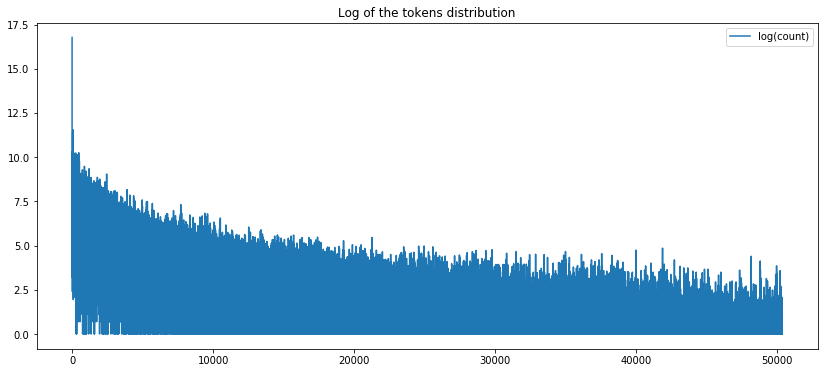

19147029

In [12]:
plt.figure(figsize=(14, 6))
plt.plot(np.log(indexer.distrib.values()))
plt.title('Log of the tokens distribution')
plt.legend(['log(count)'])
plt.show()
indexer.distrib[0]

In [25]:
# input params
vocab_size             = indexer.get_vocab_size
word_embed_vector_size = 4
sentence_len_max       = indexer.get_sentence_max_len
epochs                 = 10
batch_size             = 512

# load pre-trained embedding GloVe https://nlp.stanford.edu/projects/glove/

# Keras model
model = Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=word_embed_vector_size,input_length=sentence_len_max))
model.add(Dropout(0.04))
model.add(LSTM(units=64))
model.add(Dropout(0.10))
model.add(Dense(1, activation='sigmoid'))

In [26]:
# compile the model
adam = Adam(lr=1e-6)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', 'binary_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 4)            201484    
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 4)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                17664     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 219,213
Trainable params: 219,213
Non-trainable params: 0
_________________________________________________________________


In [27]:
# store the network architecture visualization graph to disk 
#plot_model(model, to_file='model.png', show_shapes=True)

# obtain the pydot.Graph object and render it
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [28]:
# combine all data
X = np.concatenate((term_idx_train, term_idx_test), axis=0)
y = np.append([], [y_train, y_test])

print('vocab_size=%s sentence_len_max=%s training=%s label=%s' % (vocab_size, sentence_len_max, X.shape, len(y)))

vocab_size=50371 sentence_len_max=500 training=(50000, 500) label=50000


In [29]:
# save callback
ckpt_callback = ModelCheckpoint('sentiment_weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

# train model
history = model.fit(
    x                = X,
    y                = y,
    epochs           = epochs,
    batch_size       = batch_size,
    validation_split = 0.01,
    callbacks        = [ckpt_callback],
    verbose          = 1
)

Train on 49500 samples, validate on 500 samples
Epoch 1/10
49500/49500 [==============================] - 53s 1ms/step - loss: 0.6931 - acc: 0.5058 - binary_accuracy: 0.5058 - val_loss: 0.6974 - val_acc: 0.0020 - val_binary_accuracy: 0.0020

Epoch 00001: val_loss improved from inf to 0.69744, saving model to sentiment_weights.01-0.70.hdf5
Epoch 2/10
49500/49500 [==============================] - 53s 1ms/step - loss: 0.6931 - acc: 0.5054 - binary_accuracy: 0.5054 - val_loss: 0.6975 - val_acc: 0.0020 - val_binary_accuracy: 0.0020

Epoch 00002: val_loss did not improve
Epoch 3/10
49500/49500 [==============================] - 54s 1ms/step - loss: 0.6931 - acc: 0.5057 - binary_accuracy: 0.5057 - val_loss: 0.6976 - val_acc: 0.0020 - val_binary_accuracy: 0.0020

Epoch 00003: val_loss did not improve
Epoch 4/10
49500/49500 [==============================] - 54s 1ms/step - loss: 0.6931 - acc: 0.5059 - binary_accuracy: 0.5059 - val_loss: 0.6977 - val_acc: 0.0020 - val_binary_accuracy: 0.0020

E

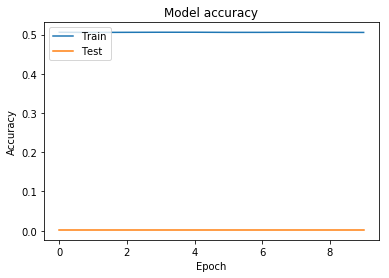

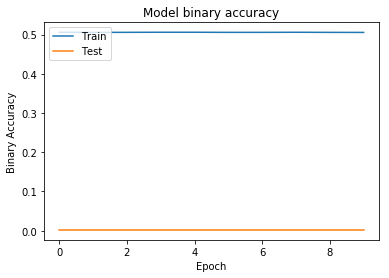

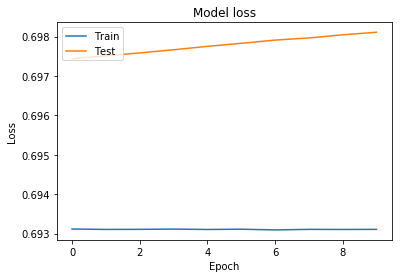

In [31]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation binary accuracy values
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model binary accuracy')
plt.ylabel('Binary Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [75]:
y_pred_lstm = model.predict(x=term_idx_train, batch_size=batch_size)
accuracy_train_lstm = (y_train == y_pred_lstm).mean()

In [76]:
pd.DataFrame(y_pred_lstm).describe()

,0
count,25000.000000
mean,0.500255
std,0.000086
min,0.498360
25%,0.500322
50%,0.500322
75%,0.500322
max,0.501654


In [77]:
y_test_pred_lstm = model.predict(x=term_idx_test, batch_size=batch_size)
accuracy_test_lstm = (y_test == y_test_pred_lstm).mean()

In [78]:
pd.DataFrame(y_pred_lstm).describe()

,0
count,25000.000000
mean,0.500255
std,0.000086
min,0.498360
25%,0.500322
50%,0.500322
75%,0.500322
max,0.501654


In [ ]:
# conclusion, we're doomed to fail, not able to train the embedding layer
# accuracy is stuck at a local minima but why always same? (optimizer is not improving from one epoch to the next)
# I will retry by hot encoding 'y', also check this https://jovianlin.io/embeddings-in-keras/ 